In [1]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    %run /Home/siv30/wad005/master/GRB/src/background_rates.ipynb
    %run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    %run /Users/andreas/phys/master/GRB/src/background_rates.ipynb
    %run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb


all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!

all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_mat

# Prepping data

dau/det starting from index 1
tus array given in seconds
safety time:  0.226 % removed
tus given in seconds
tus array OK ...


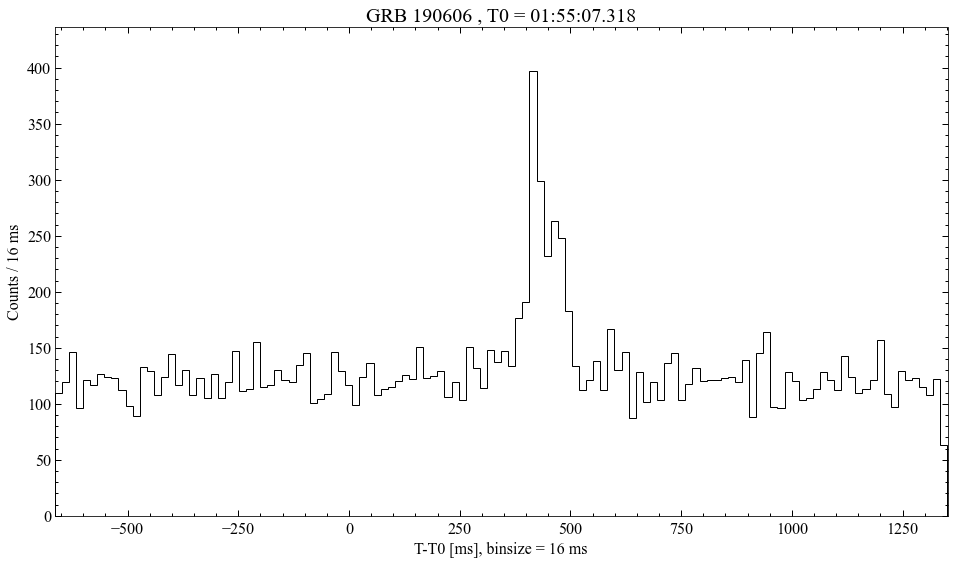

In [12]:
df = harvest_data('2019_6_6_1_55_7',T0='2019-06-06T01:55:07.318')
plot_HED(tus_arr=df['tus'].to_numpy()*1e6,T0=datetime.fromisoformat('2019-06-06T01:55:07.318'),binsize=16)

# Cross corrolation

bin start:  -0.512 bin end 1.008


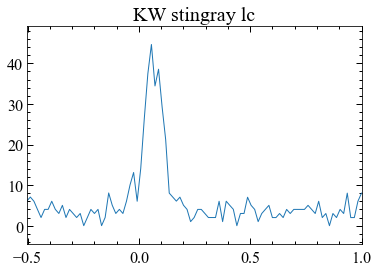

-0.512
asimBkg:  121.3


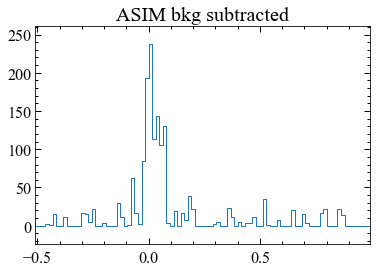

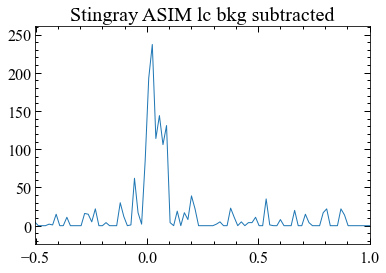

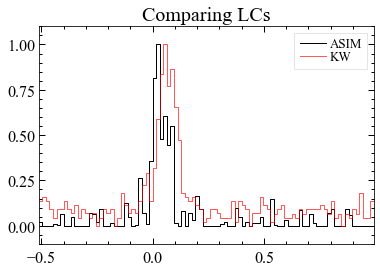

In [13]:
#KW PREP
kw_filename = "GRB190606A_16ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.016

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print("bin start: ", kw_bin_lo[0], "bin end",kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kwLC = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kwLC.plot(title='KW stingray lc')



#ASIM PREP
kevArr = df["keV"].to_numpy(dtype=np.float32)
tlagg_approx = -0.4

tus = df["tus"].to_numpy(dtype=np.float64)+tlagg_approx
#asim_bins = np.round(np.arange(min(tus),max(tus)+binsize,binsize),3)
kw_bins = np.append(kw_bin_lo,kw_bin_hi[-1])
hist = np.histogram(tus,bins=kw_bins)
asimCounts,asimEdges = hist[0],hist[1]

print(asimEdges[0])
iAsimBkgStart = find_nearest(asimEdges,min(asimEdges)+0.1)
iAsimBkgEnd = find_nearest(asimEdges,-0.25)

asimBkg = sum(asimCounts[iAsimBkgStart:iAsimBkgEnd])/len(asimCounts[iAsimBkgStart:iAsimBkgEnd])
print("asimBkg: ",asimBkg)
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg

plt.step(x=asimEdges[:-1],y=asimCounts,where="pre")
plt.title("ASIM bkg subtracted")
plt.show()

asimLC = LC(time=asimEdges[:-1]+binsize/2,counts=asimCounts,dt=0.016,skip_checks=True)
asimLC.plot(title='Stingray ASIM lc bkg subtracted')

#COMPARING LC's
plt.step(x=asimEdges[:-1],y=asimCounts/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red",alpha=0.65)
plt.legend()
plt.title('Comparing LCs')
plt.show()
#Good tlaggApprox, but ASIM needs to be shifted in + direction ~+0.03s

Total lagg (s):  -0.368 | CC lagg:  0.032


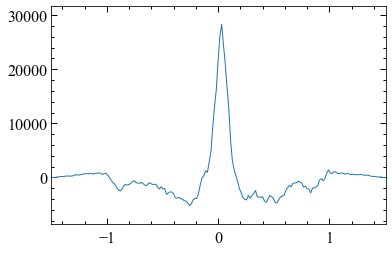

<AxesSubplot:>

In [14]:
CC = CrossCorrelation(kwLC,asimLC,mode="full")
CClagg=CC.time_shift
tlagg = tlagg_approx + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
CC.plot()

## Overlapping LC's after tlagg

asimBkg:  118.5


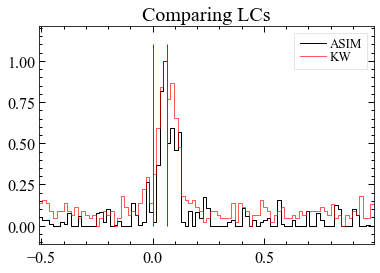

In [15]:
tus = df["tus"].to_numpy(dtype=np.float64)+tlagg
#asim_bins = np.round(np.arange(min(tus),max(tus)+binsize,binsize),3)
kw_bins = np.append(kw_bin_lo,kw_bin_hi[-1])
hist = np.histogram(tus,bins=kw_bins)
asimCounts,asimEdges = hist[0],hist[1]

iAsimBkgStart = find_nearest(asimEdges,min(asimEdges)+0.1)
iAsimBkgEnd = find_nearest(asimEdges,-0.25)

asimBkg = sum(asimCounts[iAsimBkgStart:iAsimBkgEnd])/len(asimCounts[iAsimBkgStart:iAsimBkgEnd])
print("asimBkg: ",asimBkg)
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg

#COMPARING LC's
plt.step(x=asimEdges[:-1],y=asimCounts/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red",alpha=0.65)
plt.vlines(x=0,ymin=0,ymax=1.1,color='g')
plt.vlines(x=0.064,ymin=0,ymax=1.1,color='g')
plt.legend()
plt.title('Comparing LCs')
plt.show()

In [16]:
tlagg= -0.368 #s
df['tus'] = df['tus'].to_numpy()+tlagg

tus array OK ...


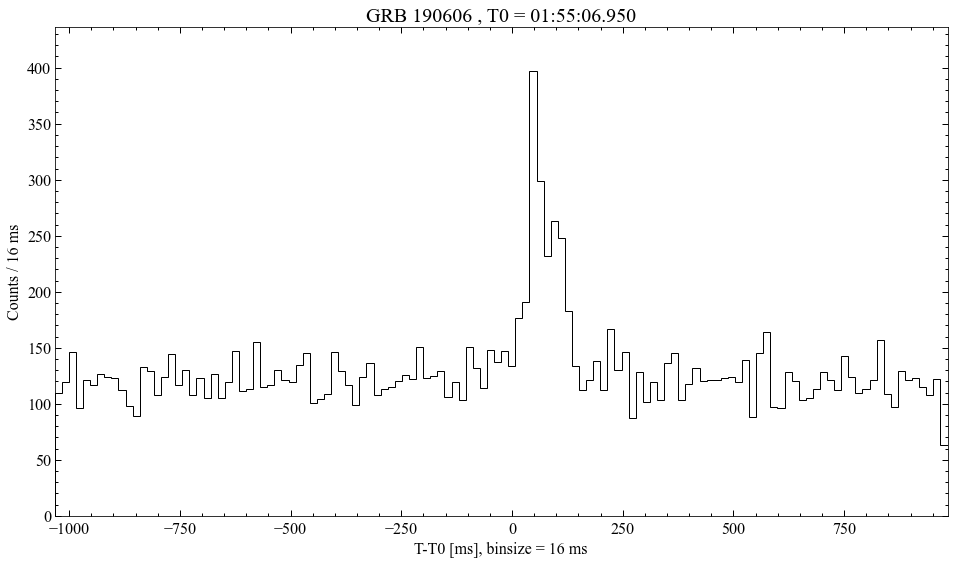

In [17]:
plot_HED(tus_arr=df['tus'].to_numpy()*1e6,binsize=16,T0=datetime.fromisoformat('2019-06-06T01:55:07.318')+timedelta(seconds=tlagg))

In [18]:
print(datetime.fromisoformat('2019-06-06T01:55:07.318')+timedelta(seconds=tlagg))

2019-06-06 01:55:06.950000


In [129]:
#next: find count rate for background, heatmap, produce new fits files

In [21]:
tus = df['tus'].to_numpy()
i_bkg_end = find_nearest(tus,-0.1)
df_bkg = df.truncate(after = i_bkg_end-1)
df_bkg

,year,month,day,hour,minute,second,erg,dau,det,datetime,tus,adr,keV,st,dt,flag
0,2019,6,6,1,55,6.65345,57,1,1,2019-06-06 01:55:06.653450278,-1.032550,1,521.501331,1.086005,0.000,False
1,2019,6,6,1,55,6.653671,80,3,3,2019-06-06 01:55:06.653671056,-1.032329,9,1845.190430,1.563460,0.000,False
2,2019,6,6,1,55,6.653671,1108,1,2,2019-06-06 01:55:06.653671083,-1.032329,2,20501.338660,19.000000,0.000,False
3,2019,6,6,1,55,6.65431,57,4,2,2019-06-06 01:55:06.654310028,-1.031690,11,765.088012,0.530176,0.000,False
4,2019,6,6,1,55,6.654433,1327,4,1,2019-06-06 01:55:06.654433444,-1.031567,10,21002.644183,21.000000,0.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7007,2019,6,6,1,55,7.585218,123,1,1,2019-06-06 01:55:07.585217556,-0.100782,1,1085.802651,3.457614,3002.500,False
7008,2019,6,6,1,55,7.585459,60,2,1,2019-06-06 01:55:07.585458778,-0.100541,4,477.828940,1.556579,1842.472,False
7009,2019,6,6,1,55,7.585459,940,2,2,2019-06-06 01:55:07.585458833,-0.100541,5,14529.063800,20.623251,9140.472,False
7010,2019,6,6,1,55,7.585459,39,2,3,2019-06-06 01:55:07.585458861,-0.100541,6,408.624022,0.086240,1070.028,False


In [22]:
tus_bkg = df_bkg['tus'].to_numpy()
len(tus_bkg)/(tus_bkg[-1]-tus_bkg[0])

7520.654229476614

In [48]:
#get_count_rate truncated before or after the tlagg implementation? 
#cr,df = get_count_rate(fn='2019_6_6_1_55_7',T0='2019-06-06T01:55:07.318')

In [34]:
#check if the same df is returned here as with count_rate function
#df_heat = static_heat(fn='2019_2_6_3_49_28',T0='2019-02-06T03:49:28.525',t_obs_start=130,t_obs_end=132,t_start=130, t_end=132,tlagg=0.0)

In [35]:
#len(df_heat['tus'].to_numpy())-len(df['tus'].to_numpy())